In [10]:
import pandas_datareader as web
from pandas_datareader import data as pdr
import yfinance as yfin
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline

In [2]:
def pull_stocks_with_pct_change(stock_names: list) -> pd.DataFrame:
    """
    Uses yahoo finance to grab to stock data
    grabs all the columns for all the stocks in stock_names
    returns a concatinated dataframe of all the stocks across available weeks
    Args:
        stock_types: The stock types to be mapped, will be mapped in the same order they appear (list)
        stock_list: The stocks to be fetched, list of lists where each embedded list is grouped by stock type (list)
    Returns:
        pandas: Dataframe of all the columns from yahoo finance for each stock is stock_list, labeled with name and type
    """
    
    #created stocktypes for testing reasons
    
    # Initialize dict that will have all stocks and its type 
    
    fullstockdata = pd.DataFrame(columns = ['Change','Stock Name'])
    
    #Gather open trading days
    appl_days = pdr.get_data_yahoo('AAPL', start=datetime(2018,2,8), end=datetime(2022,3, 10))
    appl_days = appl_days.pct_change().dropna()
    desired_days = list(appl_days.index)
    desired_days = [day.strftime('%Y-%m-%d') for day in desired_days]
    
    for ix,stock in enumerate(stock_names):
        try:
            stockdata = pdr.get_data_yahoo(str(stock.upper()), start=datetime(2018,2,8), end=datetime(2022,3, 10))

            change_data = pd.DataFrame(columns = ['Change','Stock Name'])
            change_data['Change'] = stockdata['Adj Close'].pct_change().dropna()
            change_data['Stock Name'] = stock.upper()

            fullstockdata = pd.concat([fullstockdata,change_data])
        except:
            print("Could not gather data on "+str(stock.upper()))
            pass
        
    change_data_by_stock = fullstockdata.reset_index().pivot(index = 'index', columns = 'Stock Name', values = 'Change')
    change_data_by_stock = change_data_by_stock.loc[desired_days]
    return(change_data_by_stock)

In [3]:
stocks = ['AAPL','NVDA','FTEC','GOLD','GS','TMUS','MTB','LYG','FRC','GOOG','AAL','CIBR','CVS','TSLA','VOD','EWBC','BAC','RIO','BTG','CI'] 

stock_df = pull_stocks_with_pct_change(stocks)
stock_df.head()

Stock Name,AAL,AAPL,BAC,BTG,CI,CIBR,CVS,EWBC,FRC,FTEC,GOLD,GOOG,GS,LYG,MTB,NVDA,RIO,TMUS,TSLA,VOD
index,,,,,,,,,,,,,,,,,,,,
2018-02-09,-0.004938,0.012231,0.019839,-0.049123,0.023776,0.016785,-0.016442,0.026551,0.009125,0.022136,-0.01285,0.036205,0.011975,0.002646,0.023942,0.066936,0.02774,0.005435,-0.015259,0.00493
2018-02-12,0.035773,0.040279,0.026047,0.077491,-0.001084,0.015638,0.006917,0.001091,0.011052,0.01925,0.015314,0.013644,0.015484,-0.007916,0.011664,-0.017451,0.027364,-0.018243,0.017106,-0.003154
2018-02-13,0.015572,0.010018,0.001928,-0.010274,0.009713,0.015184,0.003435,0.007782,0.006625,0.003345,-0.003017,0.000152,0.009362,0.010638,0.007578,0.020173,0.009422,-0.007398,0.025116,-0.004569
2018-02-14,0.003932,0.018437,0.026299,0.058823,0.000563,0.016221,-0.004564,0.033977,0.043655,0.020588,0.032526,0.016728,0.02759,0.013158,0.031319,0.037785,0.041824,0.016121,-0.004171,0.005297
2018-02-15,0.011748,0.033578,0.006562,0.0,-0.018461,0.018656,0.01003,-0.001942,-0.001051,0.01902,-0.022711,0.018529,0.019423,0.007792,-0.004584,0.021042,0.014817,0.031047,0.036487,0.009835


# Strategy 1: Using other stocks with 1 day shift

For this strategy, we fit a linear regression model to predict 'APPL' daily change with a 1 day shift on the other stocks in the dataset

In [4]:
targets = stock_df['AAPL'].iloc[1:]

In [5]:
stock_features = stock_df.drop(['AAPL'], axis = 1)

stock_1day_shift = stock_features.shift(periods=1).dropna()

In [6]:
X_norm = StandardScaler().fit_transform(stock_1day_shift)

X_train, X_test, y_train, y_test= train_test_split(X_norm, targets, test_size=.2, random_state=1, shuffle = False)

reg = LinearRegression()
reg.fit(X_train,y_train)

y_pred = reg.predict(X_test)

print(r2_score(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))

-0.08056386473423593
0.00024139595964962045


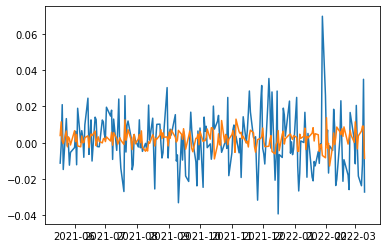

In [7]:
y_pred_series = pd.Series(y_pred)
y_pred_series.index = y_test.index
y_pred_series

plt.plot(y_test)
plt.plot(y_pred_series)

In [8]:
X_norm = StandardScaler().fit_transform(stock_1day_shift)

MSE = []
R2 = []
kf = KFold(n_splits = 10, shuffle = False)
for train_index, test_index in kf.split(X_norm):
    X_train, X_test = X_norm[train_index], X_norm[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    
    regr = LinearRegression()
    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    
    MSE.append(mean_squared_error(y_test, y_pred))
    R2.append(r2_score(y_test, y_pred))
print(np.mean(MSE))
print(np.mean(R2))

0.00043849319836951903
-0.04207025798643288


In [12]:
X_train, X_test, y_train, y_test= train_test_split(X_norm, targets, test_size=.2, random_state=1, shuffle = False)

pipeline = make_pipeline(
    LassoLarsIC(criterion="aic", normalize=False)
    )
pipeline.fit(X_train, y_train)

results = pd.DataFrame(
    {
        "alphas": pipeline[-1].alphas_,
        "AIC criterion": pipeline[-1].criterion_,
    }
    ).set_index("alphas")

pipeline.set_params(lassolarsic__criterion="bic").fit(X_train, y_train)
results["BIC criterion"] = pipeline[-1].criterion_
alpha_bic = pipeline[-1].alpha_

print(results)

          AIC criterion  BIC criterion
alphas                                
0.004493     821.000000     821.000000
0.004089     817.661197     822.371720
0.002314     794.761250     804.182296
0.001312     788.553256     802.684825
0.001177     789.751533     808.593626
0.000781     788.410591     811.963206
0.000668     788.944002     817.207141
0.000593     788.721887     821.695549
0.000571     789.788845     827.473030
0.000409     785.817367     828.212075
0.000369     786.653324     833.758555
0.000361     788.414492     840.230246
0.000360     790.390575     846.916853
0.000264     789.377105     850.613905
0.000217     790.166441     856.113765
0.000153     790.418547     861.076393
0.000119     791.673582     867.041952
0.000101     793.329443     873.408336
0.000071     794.791140     879.580556
0.000000     796.232304     885.732243


# Strategy 2: Using shifted days of AAPL stock

This is similar to an 'ARIMA' aproach. We will use a 3 day lag of appl stocks as the features for the dataset

In [17]:
aapl_df = pd.DataFrame(stock_df['AAPL'])
aapl_1day_shift = aapl_df.shift(periods=1)
aapl_2day_shift = aapl_df.shift(periods=2)
aapl_3day_shift = aapl_df.shift(periods=3)

all_shifts_aapl = aapl_df.join(aapl_1day_shift, rsuffix='_1day')
all_shifts_aapl = all_shifts_aapl.join(aapl_2day_shift, rsuffix='_2day')
all_shifts_aapl = all_shifts_aapl.join(aapl_3day_shift, rsuffix='_3day').dropna()

all_shifts_aapl.head()

,AAPL,AAPL_1day,AAPL_2day,AAPL_3day
index,,,,
2018-02-14,0.018437,0.010018,0.040279,0.012231
2018-02-15,0.033578,0.018437,0.010018,0.040279
2018-02-16,-0.003237,0.033578,0.018437,0.010018
2018-02-20,-0.003364,-0.003237,0.033578,0.018437
2018-02-21,-0.004539,-0.003364,-0.003237,0.033578


In [19]:
targets = all_shifts_aapl['AAPL']

X = all_shifts_aapl.drop(['AAPL'], axis = 1)

In [20]:
X_norm = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test= train_test_split(X_norm, targets, test_size=.2, random_state=1, shuffle = False)

reg = LinearRegression()
reg.fit(X_train,y_train)

y_pred = reg.predict(X_test)

print(r2_score(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))

-0.04073131973213906
0.00023283672080524692


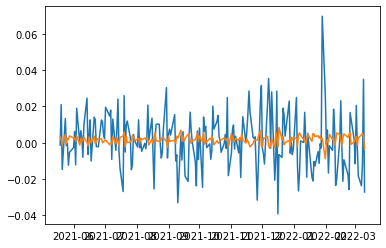

In [21]:
y_pred_series = pd.Series(y_pred)
y_pred_series.index = y_test.index
y_pred_series

plt.plot(y_test)
plt.plot(y_pred_series)

In [22]:
X_norm = StandardScaler().fit_transform(X)

MSE = []
R2 = []
kf = KFold(n_splits = 10, shuffle = False)
for train_index, test_index in kf.split(X_norm):
    X_train, X_test = X_norm[train_index], X_norm[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    
    regr = LinearRegression()
    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    
    MSE.append(mean_squared_error(y_test, y_pred))
    R2.append(r2_score(y_test, y_pred))
print(np.mean(MSE))
print(np.mean(R2))

0.0004341637998143325
-0.02171160581188596


**We do not get very accurate results from regression, which was expected. Instead, we will shift the focus to classification**